<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

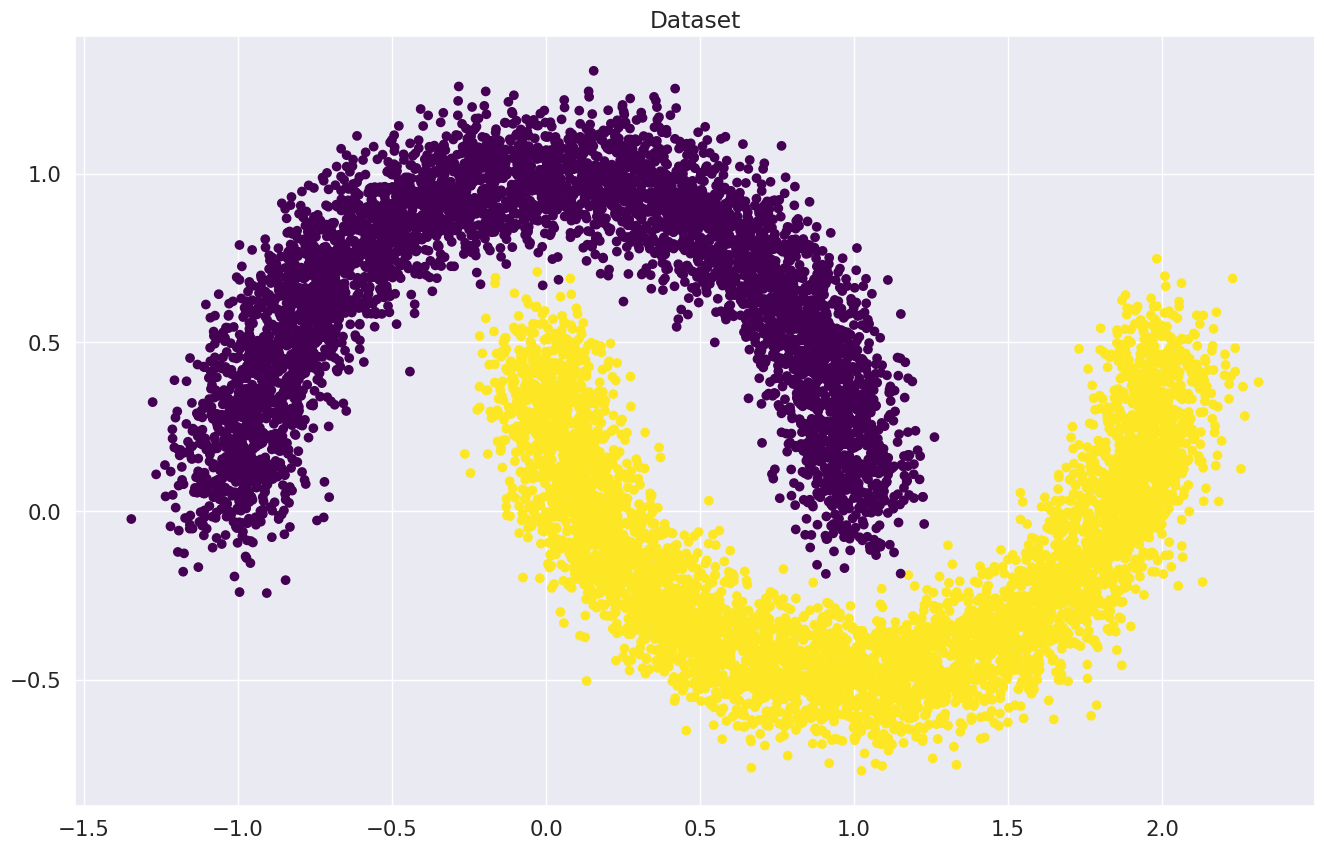

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [5]:
X_train

array([[ 0.50202001, -0.33758011],
       [-0.02001968,  0.239079  ],
       [ 0.57026061,  0.81166576],
       ...,
       [ 0.32163146, -0.35671524],
       [ 2.01344205,  0.03227946],
       [ 0.17908235,  0.93097468]])

In [6]:
y_train

array([1, 1, 0, ..., 1, 1, 0])

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [7]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long) # Тип данных для меток (labels): Когда используется функции потерь в PyTorch, такие как CrossEntropyLoss, они ожидают, что метки будут иметь тип torch.long.
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)

Создаем `Dataset` и `DataLoader`.

In [8]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [9]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.ones(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [10]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [11]:
def count_parameters(in_features, out_features, bias=True):
    # Подсчет параметров для весов
    weight_params = in_features * out_features

    # Подсчет параметров для смещения (если есть)
    bias_params = out_features if bias else 0

    # Общее количество параметров
    total_params = weight_params + bias_params

    return total_params

In [12]:
in_features_example = 2
out_features_example = 1
print('Общее количество параметров =', count_parameters(in_features_example, out_features_example, bias=True))

Общее количество параметров = 3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [13]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch) # Use linear_regression to get outputs
        loss = loss_function(outp.flatten(), y_batch.float()) # Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp.flatten()) # Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.3046875
Iteration: 100
Batch accuracy: 0.8359375
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.9140625
Iteration: 600
Batch accuracy: 0.875

Iteration: 696.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 696

### Визуализируем результаты

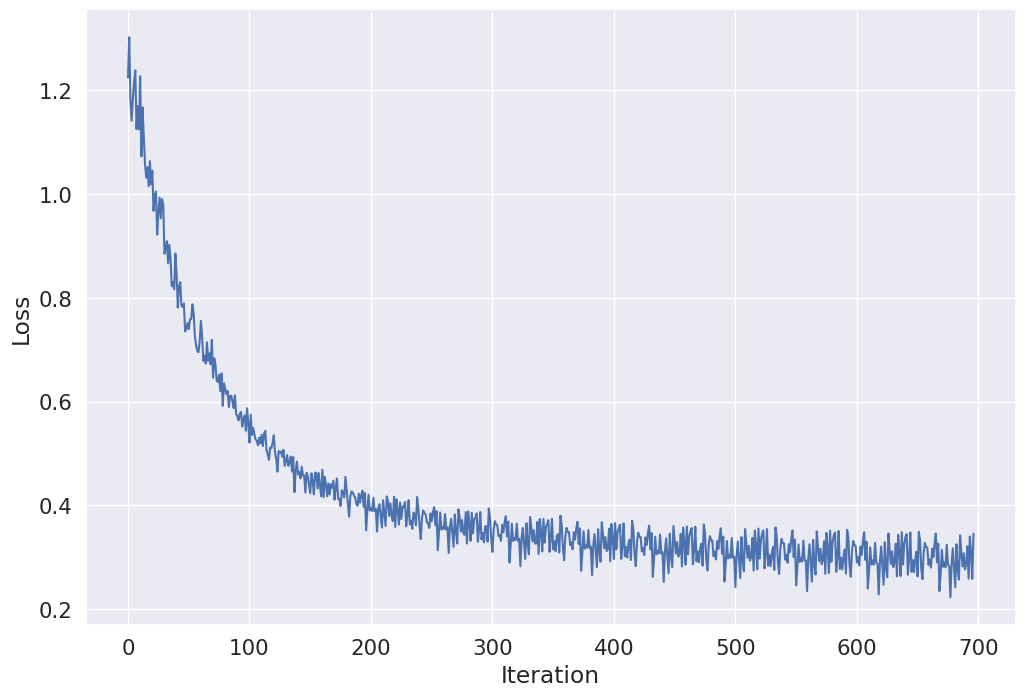

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

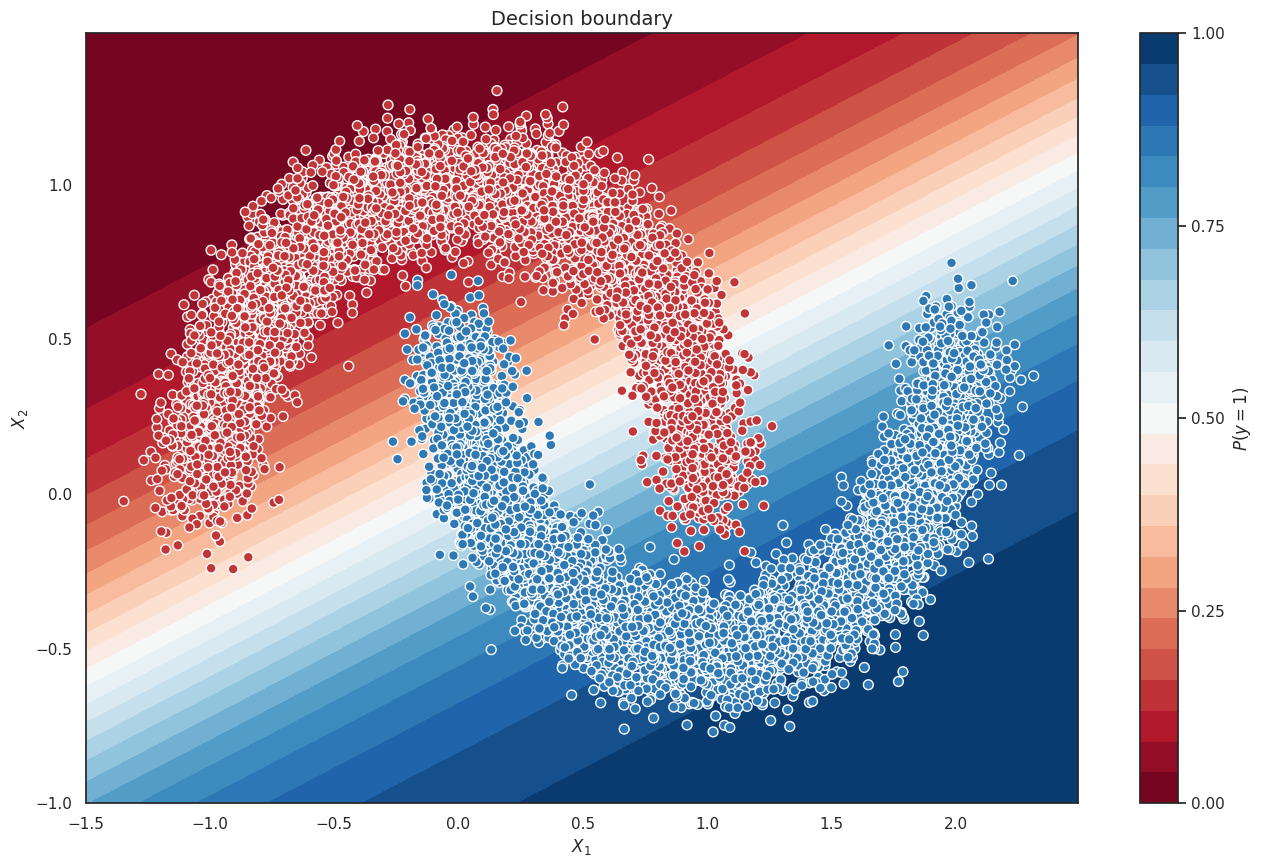

In [15]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [16]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        # Compute predictions
        preds = (torch.sigmoid(outp) > 0.5).type(torch.float32)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [17]:
from sklearn.metrics import accuracy_score

predicted_labels = predict(val_dataloader, linear_regression)
true_labels = np.array([label for _, label in val_dataloader.dataset])

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.872


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8636

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [18]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128

train_dataloader =  DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
valid_dataloader =  DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 96642525.81it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 79642139.27it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27196653.44it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15301629.53it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [19]:
x_batch, y_batch = next(iter(train_dataloader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [20]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [21]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10),
    nn.Softmax(dim=1)
)

In [22]:
criterion = nn.CrossEntropyLoss() # Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [24]:
for k, dataloader in loaders.items():
  print(k)
  print(dataloader)

train
valid


### Задание. Дополните цикл обучения.

In [25]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
              # loss = criterion(outp, y_batch)
              # loss.backward()
              # optimizer.step()
            else:
              # Set model to ``eval`` mode and calculate outputs
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8440671741452992
Loader: valid. Accuracy: 0.9123597756410257
Epoch: 2
Loader: train. Accuracy: 0.9179019764957265
Loader: valid. Accuracy: 0.9336939102564102
Epoch: 3
Loader: train. Accuracy: 0.9354801014957265
Loader: valid. Accuracy: 0.9456129807692307
Epoch: 4
Loader: train. Accuracy: 0.9466312767094017
Loader: valid. Accuracy: 0.9524238782051282
Epoch: 5
Loader: train. Accuracy: 0.9532251602564102
Loader: valid. Accuracy: 0.9502203525641025
Epoch: 6
Loader: train. Accuracy: 0.9582331730769231
Loader: valid. Accuracy: 0.9573317307692307
Epoch: 7
Loader: train. Accuracy: 0.9627236912393162
Loader: valid. Accuracy: 0.9604366987179487
Epoch: 8
Loader: train. Accuracy: 0.9648771367521367
Loader: valid. Accuracy: 0.9603365384615384
Epoch: 9
Loader: train. Accuracy: 0.967331063034188
Loader: valid. Accuracy: 0.9635416666666666
Epoch: 10
Loader: train. Accuracy: 0.9680321848290598
Loader: valid. Accuracy: 0.9561298076923077


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [26]:
elu_accuracy = accuracy["valid"]

In [27]:
elu_accuracy

[0.9123597756410257,
 0.9336939102564102,
 0.9456129807692307,
 0.9524238782051282,
 0.9502203525641025,
 0.9573317307692307,
 0.9604366987179487,
 0.9603365384615384,
 0.9635416666666666,
 0.9561298076923077]

In [28]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

# def test_activation_function(activation):
    #YOUR CODE

In [29]:
def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 128),
        activation,
        nn.Linear(128, 128),
        activation,
        nn.Linear(128, 10)
    )
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    criterion = nn.CrossEntropyLoss()

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                  model.train()
                  optimizer.zero_grad()
                  outp = model(x_batch)
                else:
                  model.eval()
                  with torch.no_grad():
                    outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = y_batch.size(0)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy

In [30]:
print('plain')
plain_accuracy = test_activation_function(Identical())
print('relu')
relu_accuracy = test_activation_function(nn.ReLU())
print('leaky')
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())

plain
Epoch: 1
Loader: train. Accuracy: 0.8448851495726496
Loader: valid. Accuracy: 0.8963341346153846
Epoch: 2
Loader: train. Accuracy: 0.9000400641025641
Loader: valid. Accuracy: 0.9033453525641025
Epoch: 3
Loader: train. Accuracy: 0.9062333066239316
Loader: valid. Accuracy: 0.9064503205128205
Epoch: 4
Loader: train. Accuracy: 0.9098557692307693
Loader: valid. Accuracy: 0.9077524038461539
Epoch: 5
Loader: train. Accuracy: 0.9124766292735043
Loader: valid. Accuracy: 0.9080528846153846
Epoch: 6
Loader: train. Accuracy: 0.9137787126068376
Loader: valid. Accuracy: 0.9082532051282052
Epoch: 7
Loader: train. Accuracy: 0.9151141826923077
Loader: valid. Accuracy: 0.9085536858974359
Epoch: 8
Loader: train. Accuracy: 0.9161324786324786
Loader: valid. Accuracy: 0.9076522435897436
Epoch: 9
Loader: train. Accuracy: 0.9170840010683761
Loader: valid. Accuracy: 0.9073517628205128
Epoch: 10
Loader: train. Accuracy: 0.9179353632478633
Loader: valid. Accuracy: 0.9072516025641025
relu
Epoch: 1
Loader: t

In [31]:
# plain_accuracy = test_activation_function(Identical)
# relu_accuracy = #YOUR CODE
# leaky_relu_accuracy = #YOUR CODE

In [32]:
plain_accuracy = plain_accuracy['valid']

In [33]:
relu_accuracy = relu_accuracy['valid']

In [34]:
leaky_relu_accuracy  = leaky_relu_accuracy['valid']

In [35]:
acc_list = [plain_accuracy, elu_accuracy, relu_accuracy, leaky_relu_accuracy]

import pandas as pd

df = pd.DataFrame(acc_list).T
df.columns = ['plain', 'elu', 'relu', 'leaky']
df

,plain,elu,relu,leaky
0,0.896334,0.912360,0.898838,0.899639
1,0.903345,0.933694,0.923578,0.922376
2,0.906450,0.945613,0.938902,0.935497
3,0.907752,0.952424,0.948117,0.945713
4,0.908053,0.950220,0.955028,0.953225
5,0.908253,0.957332,0.958133,0.958634
6,0.908554,0.960437,0.962139,0.961238
7,0.907652,0.960337,0.964143,0.964643
8,0.907352,0.963542,0.965946,0.967248
9,0.907252,0.956130,0.966947,0.968349


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

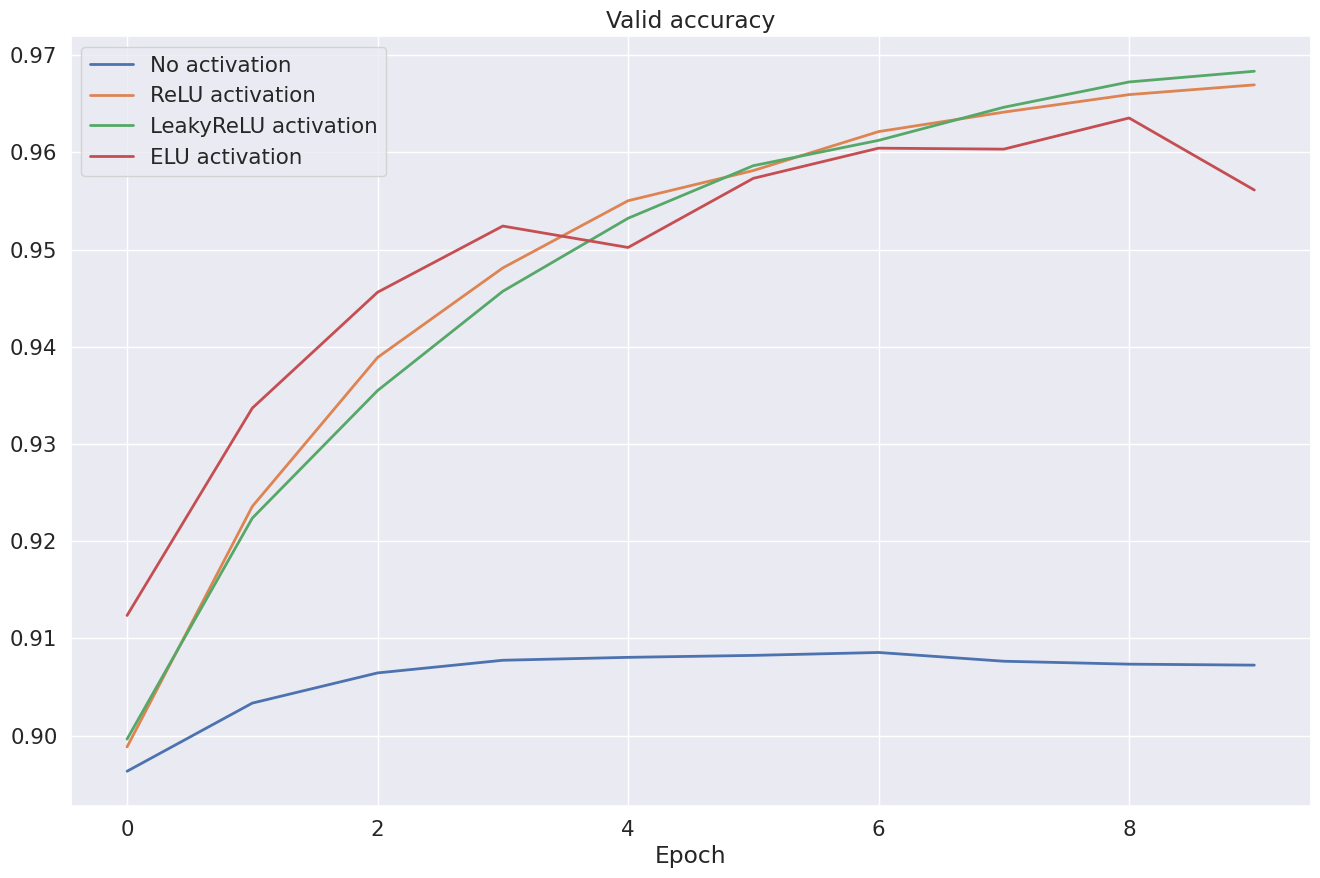

In [36]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

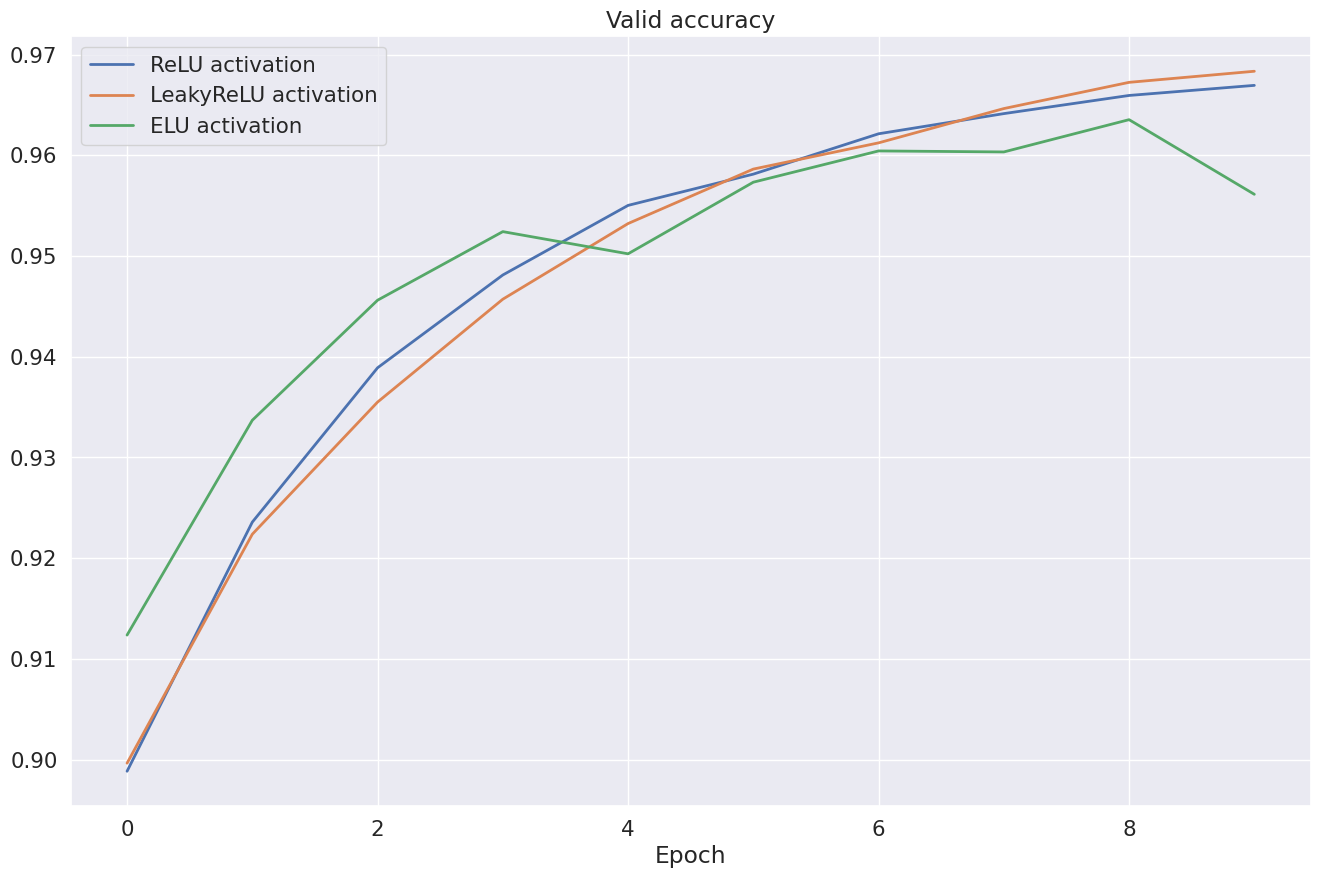

In [37]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** Leaky ReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [38]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-10-25 09:12:46--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   235KB/s    in 0.2s    

2023-10-25 09:12:46 (235 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



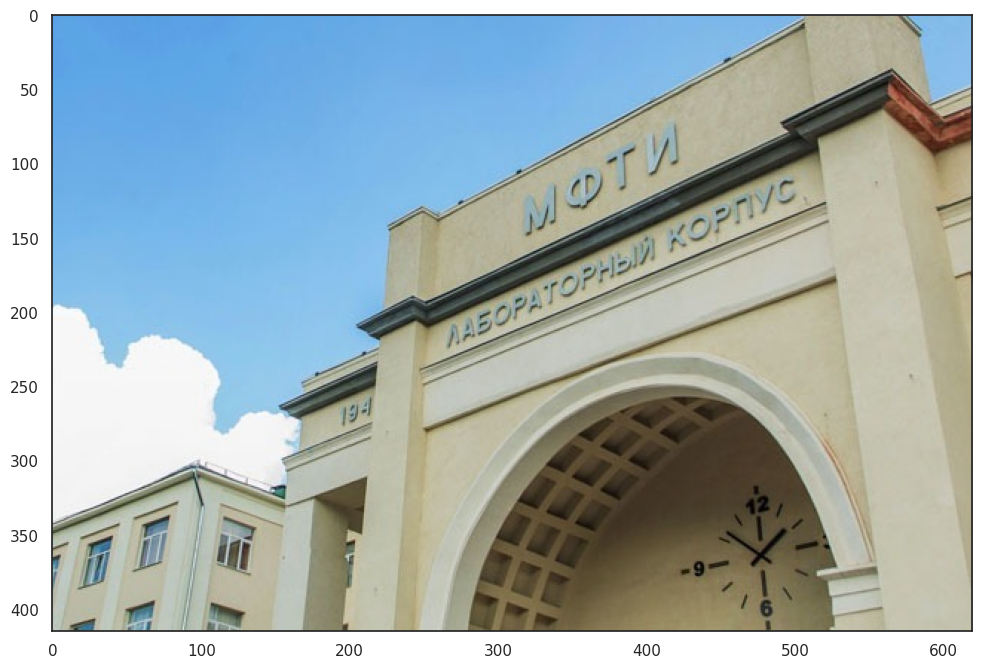

In [39]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [56]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

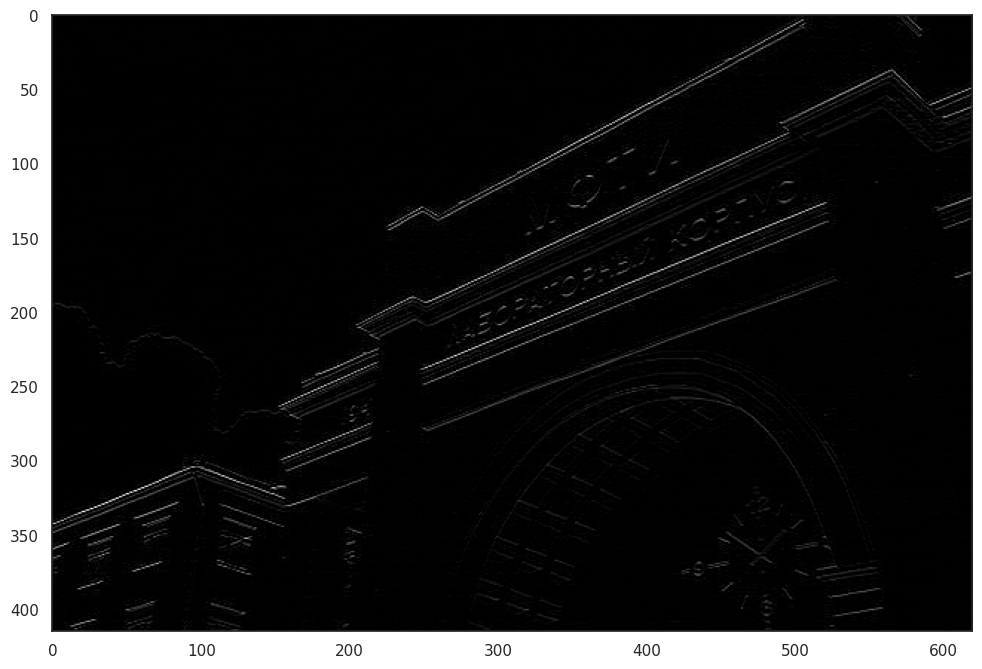

In [57]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

А - Тождественное преобразование

Б - Выделение горизонтальных границ

В - Выделение границ

Г - Выделение вертикальных границ

Д - Увеличение резкости

Е - Размытие


### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [67]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3,3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(2,2))
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        # flatten
        self.flatten = nn.Flatten()
        # linear
        self.fc1 = nn.Linear(16 * 6 *6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # print(x.shape)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [68]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [69]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              # Set model to ``eval`` mode and calculate outputs
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8534488514957265
Loader: valid. Accuracy: 0.9547275641025641
Epoch: 2
Loader: train. Accuracy: 0.9635416666666666
Loader: valid. Accuracy: 0.9712540064102564
Epoch: 3
Loader: train. Accuracy: 0.9753104967948718
Loader: valid. Accuracy: 0.9781650641025641
Epoch: 4
Loader: train. Accuracy: 0.9810864049145299
Loader: valid. Accuracy: 0.9821714743589743
Epoch: 5
Loader: train. Accuracy: 0.9850761217948718
Loader: valid. Accuracy: 0.9850761217948718
Epoch: 6
Loader: train. Accuracy: 0.9873965010683761
Loader: valid. Accuracy: 0.985176282051282
Epoch: 7
Loader: train. Accuracy: 0.9897502670940171
Loader: valid. Accuracy: 0.9837740384615384
Epoch: 8
Loader: train. Accuracy: 0.9914362980769231
Loader: valid. Accuracy: 0.984375
Epoch: 9
Loader: train. Accuracy: 0.9925213675213675
Loader: valid. Accuracy: 0.9844751602564102
Epoch: 10
Loader: train. Accuracy: 0.9930722489316239
Loader: valid. Accuracy: 0.9855769230769231


In [70]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

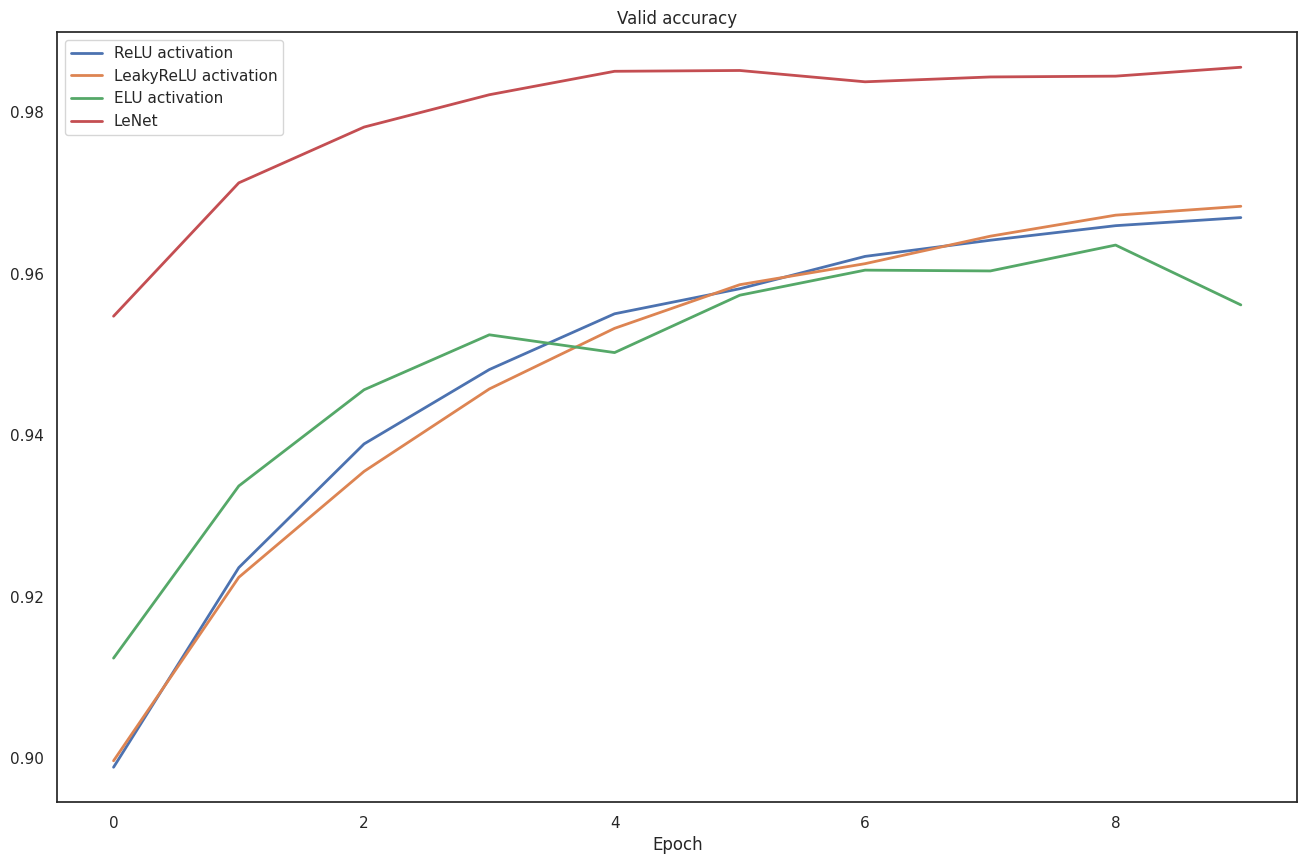

In [71]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0,98